In [1]:
import os
import shutil
import pathlib
from glob import glob
import warnings
import subprocess

import earthpy as et
import earthpy.earthexplorer as etee
import earthpy.spatial as es
import geopandas as gpd
import geoviews as gv
import hvplot.pandas
import hvplot.xarray
import holoviews as hv
import numpy as np
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rxrmerge


# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME)
den_dir = os.path.join(data_dir, 'denver-neighborhoods')
ndvi_dir = os.path.join(data_dir, 'denver-green-space', 'processed')

for a_dir in [den_dir, ndvi_dir]:
        if not os.path.exists(a_dir):
                os.makedirs(a_dir)

In [2]:
den_path = os.path.join(den_dir, 'denver-neighborhoods.shp')

if not os.path.exists(den_path):
    den_url = (
        'https://www.denvergov.org/media/gis/DataCatalog/'
        'statistical_neighborhoods/shape/statistical_neighborhoods.zip')
    gpd.read_file(den_url).to_file(den_path)

den_gdf = gpd.read_file(den_path)

den_gdf

neigh_gdf = (
    den_gdf
    .set_index('NBHD_NAME')
     .loc[['City Park']]
)
neigh_gdf.total_bounds
# neigh_gdf = neigh_gdf.to_crs(3857)
# den_gdf = den_gdf.to_crs(3857)

array([-104.95979014,   39.73998912, -104.94062104,   39.75116547])

In [3]:
gv.tile_sources.OSM * neigh_gdf.to_crs(3857).hvplot(
    line_color='Black', fill_color=None, line_width=3,
    xaxis=None, yaxis=None)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [x,y]

In [4]:
bbox = etee.BBox(*neigh_gdf.total_bounds)
naip_downloader = etee.EarthExplorerDownloader(
    dataset="NAIP", 
    label='denver-green-space', 
    bbox=bbox,
    start='2019-01-01', 
    end='2019-12-31',
    store_credential=True)
naip_downloader.submit_download_request()
naip_downloader.download(override=False)

Login Successful.
Searching datasets...
Using dataset alias: naip
Searching scenes...
Found 2 scenes
4 products found.
Downloads staging...
C:\Users\tayob\earth-analytics\data\denver-green-space\M_3910417_NW_13_060_20190803.zip
C:\Users\tayob\earth-analytics\data\denver-green-space\M_3910409_SW_13_060_20190803.zip
C:\Users\tayob\earth-analytics\data\denver-green-space\M_3910409_SW_13_060_20190803.zip
C:\Users\tayob\earth-analytics\data\denver-green-space\M_3910417_NW_13_060_20190803.zip


In [5]:
naip_downloader.wait_for_available_downloads()

{'available': [], 'queueSize': 0, 'requested': [], 'eulas': []}

In [6]:
def download_neighborhood_data(name, geometry, start, end):
    """
    Download NAIP raster for a given geometry, start date, and end date

    Parameters
    ==========
    name : str
      The name used to label the download
    geometry : shapely.POLYGON
      The geometry to derive the download extent from. 
      Must have a `.bounds` attribute.
    start : str
      The start date as 'YYYY-MM-DD'
    end : str
      The end date as 'YYYY-MM-DD'

    Returns
    =======
    downloader : earthpy.earthexplorer.EarthExplorerDownloader
      Object with information about the download, including the data directory.
    """
    print(f'\nNeighborhood name: {name}')
    bbox = etee.BBox(*geometry.bounds)
    naip_downloader = etee.EarthExplorerDownloader(
        dataset="NAIP", 
        label=name.lower().replace(' ', '-'), 
        bbox=bbox,
        start=start, 
        end=end,
        store_credential=True)
    naip_downloader.submit_download_request()
    naip_downloader.download(override=False)
    return naip_downloader

ndvi_stats_path = os.path.join(ndvi_dir, 'neighborhood-ndvi-stats.csv')
if os.path.exists(ndvi_stats_path):
    print('Reading in NDVI statistics file...')
    ndvi_stats_df = pd.read_csv(ndvi_stats_path, index_col='neighborhood')
else:
    print('NDVI statistics file does not exist...')
    ndvi_stats_df = pd.DataFrame()

for neighborhood_name, details in neigh_gdf.iterrows():
    if neighborhood_name in ndvi_stats_df.index:
      print('Neighborhood stats have already been calculated. Skipping')
      continue
    downloader = download_neighborhood_data(
        neighborhood_name, details.geometry, '2019-01-01', '2019-12-31')

Reading in NDVI statistics file...
Neighborhood stats have already been calculated. Skipping


In [7]:
naip_downloader.wait_for_available_downloads()

{'available': [], 'queueSize': 0, 'requested': [], 'eulas': []}

In [8]:
def load_and_merge_arrays(name):
    """
    Load in and merge downloaded arrays

    Parameters
    ==========
    name : str
      The name used to label the download

    Returns
    =======
    merge_da : rxr.DataArray
        DataArray with the merged data
    """

    print(f'\nNeighborhood name: {name}')
    data_path = os.path.join(
        et.io.HOME, et.io.DATA_NAME,
        name.lower().replace(' ', '-'))
    tif_paths = glob(os.path.join(data_path, '*.tif'))
    das = [rxr.open_rasterio(tp, masked=True) for tp in tif_paths]
    merged_da = rxrmerge.merge_arrays(das)
    return merged_da

merged_da = load_and_merge_arrays('City Park')
merged_da


Neighborhood name: City Park


<xarray.DataArray (band: 4, y: 23800, x: 18530)>
array([[[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [ 33.,  33.,  39., ...,  82.,  57.,  48.],
        [ 32.,  33.,  38., ...,  51.,  42.,  37.],
        [ 33.,  32.,  35., ...,  40.,  39.,  37.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [ 39.,  39.,  47., ...,  78.,  56.,  46.],
        [ 36.,  38.,  43., ...,  49.,  43.,  37.],
        [ 37.,  36.,  41., ...,  44.,  41.,  41.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [ 40.,  39.,  40., ...,  76.,  60.,  52.],
        [ 39.,  37.,  40., ...,  55.,  47.,  44.],
        [ 40.,  37.,  39., ...,  49.,  46.,  44.]],

       [[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [ 84.,  99., 166., ...,  45.,  37.,  34.],
        [ 66.,  82., 136., ...,  35.,  33.,  32.],
        [ 72.,  73., 118., ...,  40.,  48.,  59.]]], dtype=float32)
Coordinates:
  * x            (x) float64 4.944e+05 4.944e+05 ... 5.056e+05 5.056e+05
  * y            (y) float64 4.407e+06 4.407e+06 ... 4.393e+06 4.393e+06
  * band         (band) int32 1 2 3 4
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    scale_factor:              1.0
    add_offset:                0.0

In [9]:
den_gdf = den_gdf.set_index('NBHD_NAME')

In [10]:
def calculate_ndvi_statistics(gdf, da, stats_path, override=False):
    """
    Calculate NDVI, then summarize and save statistics

    Uses downloaded National Agricultural Imagery Program (NAIP)
    data. <citation>

    Parameters
    ==========
    gdf : gpd.GeoDataFrame
      One row with the neighborhood name and boundary
    da : rxr.DataArray
        Multispectral (NAIP) raster data
    stats_path: pathlike
        The path to the statistics file to save results
    """
    name = str(gdf.index[0])
    print(f'Neighborhood name: {name}')

    file_is_empty = True
    if os.path.exists(stats_path):
        print('Stats file exists.')
        stats_df = pd.read_csv(stats_path)
        file_is_empty = len(stats_df)==0
        print(f'Stats file is empty? {file_is_empty}')

        if not file_is_empty:
            if (name in list(stats_df.neighborhood)) and (not override):
                print('Stats already calculated. Skipping...')
                return
    
    reprojected_gdf = gdf.to_crs(da.rio.crs)

    naip_crop_da = da.rio.clip_box(*reprojected_gdf.total_bounds)
    naip_da = naip_crop_da.rio.clip(reprojected_gdf.geometry)

    ndvi_da = (
        (da.sel(band=4) - da.sel(band=1))
        / (da.sel(band=4) + da.sel(band=1))
    )
    
    mode = 'w' if file_is_empty else 'a'
    pd.DataFrame(dict(
        neighborhood=[name],
        ndvi_min=[float(ndvi_da.min())],
        ndvi_max=[float(ndvi_da.max())],
        ndvi_median=[float(ndvi_da.median())],
        ndvi_25pctl=[np.nanpercentile(ndvi_da.values, 25)],
        ndvi_75pctl=[np.nanpercentile(ndvi_da.values, 75)],
        ndvi_mean=[float(ndvi_da.mean())],
        ndvi_std=[float(ndvi_da.std())]
    )).to_csv(stats_path, mode='a', header=file_is_empty)

calculate_ndvi_statistics(
    den_gdf.loc[['City Park']], merged_da, ndvi_stats_path)

Neighborhood name: City Park
Stats file exists.
Stats file is empty? False
Stats already calculated. Skipping...


In [11]:
ndvi_stats_path = os.path.join(ndvi_dir, 'neighborhood-ndvi-stats.csv')

for neighborhood_name, details in neigh_gdf.iterrows():
    if not os.path.exists(ndvi_stats_path):
        print('NDVI statistics file does not exist...')
        ndvi_stats_df = pd.DataFrame()
    else:
        ndvi_stats_df = pd.read_csv(ndvi_stats_path, index_col="neighborhood")
    
    if neighborhood_name in ndvi_stats_df.index:
      print('Neighborhood stats have already been calculated. Skipping')
      continue
    downloader = download_neighborhood_data(
        neighborhood_name, details.geometry, '2019-01-01', '2019-12-31')
    merged_da = load_and_merge_arrays(neighborhood_name)
    calculate_ndvi_statistics(
        den_gdf.loc[[neighborhood_name]], merged_da, ndvi_stats_path)
    
    
    shutil.rmtree(downloader.data_dir)

Neighborhood stats have already been calculated. Skipping


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
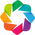

In [12]:
ndvi_stats_df = pd.read_csv(ndvi_stats_path, index_col="neighborhood")
polygons = gv.Polygons(neigh_gdf.join(ndvi_stats_df, how='left'), vdims=['ndvi_mean'])
color_scale = 'viridis'
chloropleth = gv.tile_sources.StamenToner * polygons.opts(
    title='NDVI Mean Chloropleth',
    cmap=color_scale,
    colorbar=True
)
hv.extension('bokeh')
hv.save(chloropleth, 'chloropleth_plot.html')